# Introducción a la paquetería Statsmodels de Python (parte 2)

In [12]:
import pandas as pd
import statsmodels.api as sm
from IPython.display import Image


from patsy import dmatrices
# Importa la biblioteca patsy, que permite describir modelos estadísticos mediante 
# fórmulas simbólicas estilo R (por ejemplo: 'y ~ x1 + x2')
# Se utiliza de forma interna en statsmodels.formula.api, pero también puede emplearse directamente para 
# generar matrices de diseño (diseño de variables independientes y dependientes)

## Importación de datos

In [4]:
df = sm.datasets.get_rdataset("Guerry", "HistData").data

## Variables dependientes e independientes
En este caso, no vamos a utilizar todas las variables que vienen en el dataset.

In [6]:
df = sm.datasets.get_rdataset("Guerry", "HistData").data

# Se define una lista de variables de interés
vars = ["Department", "Lottery", "Literacy", "Wealth", "Region"]

# Se hace un filtro sobre el dataset original
df = df[vars]

In [7]:
df.head()

,Department,Lottery,Literacy,Wealth,Region
0,Ain,41,37,73,E
1,Aisne,38,51,22,N
2,Allier,66,13,61,C
3,Basses-Alpes,80,46,76,E
4,Hautes-Alpes,79,69,83,E


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86 entries, 0 to 85
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Department  86 non-null     object
 1   Lottery     86 non-null     int64 
 2   Literacy    86 non-null     int64 
 3   Wealth      86 non-null     int64 
 4   Region      85 non-null     object
dtypes: int64(3), object(2)
memory usage: 3.5+ KB


Vemos que tenemos una variable categórica **Region**. Podemos checar rápidamente con pandas cuales son los valores únicos para esta variable.

In [9]:
df["Region"].unique()

array(['E', 'N', 'C', 'S', 'W', nan], dtype=object)

Vemos que tenemos un valor nulo. Como solo es 1 podemos quitarlo con el método `dropna()`de pandas.

In [10]:
df = sm.datasets.get_rdataset("Guerry", "HistData").data

vars = ["Department", "Lottery", "Literacy", "Wealth", "Region"]
df = df[vars]
df = df.dropna() # se eliminan filas que contengan algún valor nulo

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 85 entries, 0 to 84
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Department  85 non-null     object
 1   Lottery     85 non-null     int64 
 2   Literacy    85 non-null     int64 
 3   Wealth      85 non-null     int64 
 4   Region      85 non-null     object
dtypes: int64(3), object(2)
memory usage: 4.0+ KB


## Utilizando matrices para OLS

El modelo lineal se expresa de forma matricial por $Y = X \beta + \epsilon$ (cada variables es una matriz), expresada de la siguiente forma:


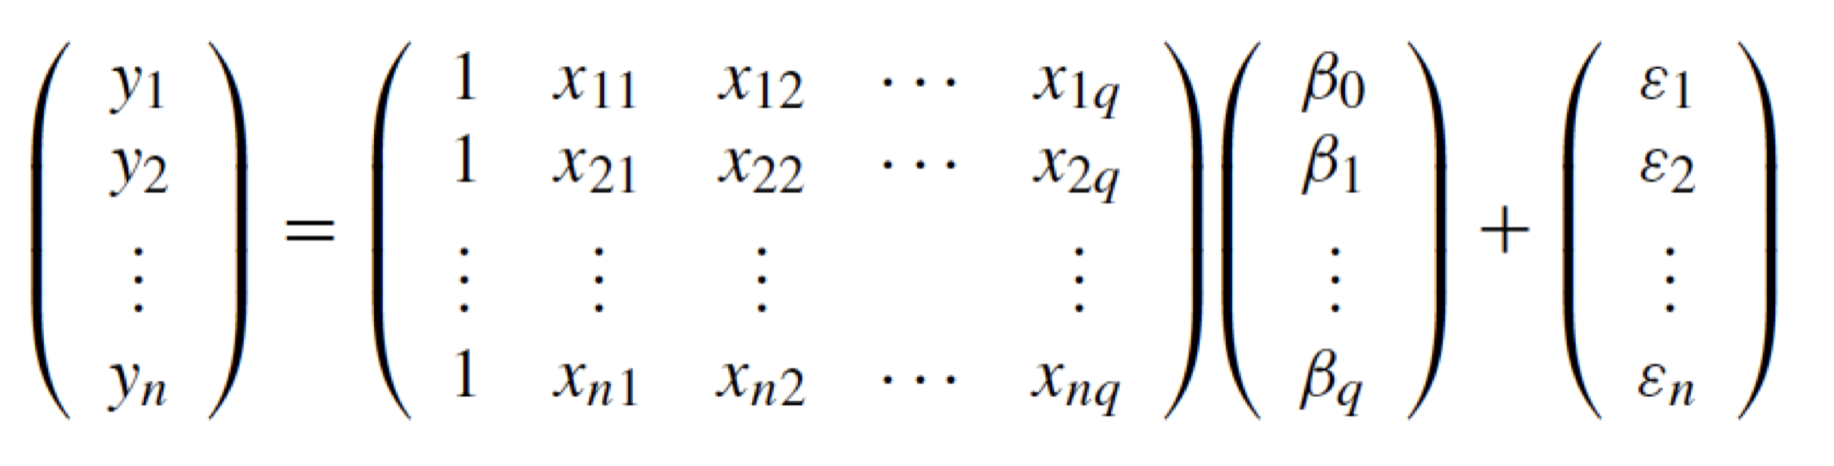

In [14]:
Image(filename = "images/Matrices.png")

El número de filas $n$ corresponde al número de observaciones de los datos (en este caso 85 filas). El número de variables de entrada está dado por $q$, y este valor nos resulta en el número de variables a ajustar para el modelo lineal $\beta_0, \beta_1 \ldots \beta_q$. Por lo tanto, las dimensiones de las matrices son las siguientes, $Y (n \times 1)$, $X (n \times (q+1))$, $\beta ((q+1) \times 1)$, $\epsilon (n \times 1)$. Recordar que una operación entre matrices tiene que tomar en cuenta las dimensiones entre ellas, y normalmente no es conmutativa $(XY \ne YX)$.

**Solución al problema de regresión lineal múltiple por mínimos cuadrados ordinarios (OLS)**
En un problema de regresión lineal multivariable, el vector de parámetros óptimos $\beta$ se encuentra utilizando normalmente el método de mínimos cuadrados ordinarios (OLS), utilizando la siguiente ecuación,

\begin{equation}
\beta = (X^TX)^{-1}X^TY
\end{equation}

Entonces, primero tenemos que ir construyendo las matrices. Para esto podemos utilizar la librería `patsy` y su método `dmatrices` importada al principio, y utilizar la sintaxis de formula de R.

In [23]:
# Se crean las matrices X, Y
y, X = dmatrices('Lottery ~ Literacy + Wealth + Region', data=df, return_type='dataframe')

In [24]:
# El tipo de variable que nos regresa se especifica como dataframe
type(y)

pandas.core.frame.DataFrame

In [25]:
y

,Lottery
0,41.0
1,38.0
2,66.0
3,80.0
4,79.0
...,...
80,68.0
81,40.0
82,55.0
83,14.0


In [26]:
X

,Intercept,Region[T.E],Region[T.N],Region[T.S],Region[T.W],Literacy,Wealth
0,1.0,1.0,0.0,0.0,0.0,37.0,73.0
1,1.0,0.0,1.0,0.0,0.0,51.0,22.0
2,1.0,0.0,0.0,0.0,0.0,13.0,61.0
3,1.0,1.0,0.0,0.0,0.0,46.0,76.0
4,1.0,1.0,0.0,0.0,0.0,69.0,83.0
...,...,...,...,...,...,...,...
80,1.0,0.0,0.0,0.0,1.0,28.0,56.0
81,1.0,0.0,0.0,0.0,1.0,25.0,68.0
82,1.0,0.0,0.0,0.0,0.0,13.0,67.0
83,1.0,1.0,0.0,0.0,0.0,62.0,82.0


Observamos que este método automáticamente nos puso la columna de 1's que requerimos en la matriz $X$ de entrada. Además de esto, observamos que también nos **codifica** las variables categóricas en variables dummy (1 ó 0). Es decir, estos datos ya se transforman de tal manera que ya se puede ajustar un modelo.

## Ajuste del modelo y summary

In [27]:
# Descripción del modelo
mod = sm.OLS(y,X) # para esta api, no usamos la formula, sino los array directamente

# Ajuste del modelo
res = mod.fit()

# Resumen del modelo
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Lottery   R-squared:                       0.338
Model:                            OLS   Adj. R-squared:                  0.287
Method:                 Least Squares   F-statistic:                     6.636
Date:                Thu, 22 May 2025   Prob (F-statistic):           1.07e-05
Time:                        19:41:42   Log-Likelihood:                -375.30
No. Observations:                  85   AIC:                             764.6
Df Residuals:                      78   BIC:                             781.7
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      38.6517      9.456      4.087      0.000      19.826      57.478
Region[T.E]   -15.4278      9.727     -1.586      0.117     -34.793       3.938
Region[T.N]   -10.0170      9.260     -1.082      0.283     -28.453       8.419
Region[T.S]    -4.5483      7.279     -0.625      0.534     -19.039       9.943
Region[T.W]   -10.0913      7.196     -1.402      0.165     -24.418       4.235
Literacy       -0.1858      0.210     -0.886      0.378      -0.603       0.232
Wealth          0.4515      0.103      4.390      0.000       0.247       0.656
==============================================================================
Omnibus:                        3.049   Durbin-Watson:                   1.785
Prob(Omnibus):                  0.218   Jarque-Bera (JB):                2.694
Skew:                          -0.340   Prob(JB):                        0.260
Kurtosis:                       2.454   Cond. No.                         371.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Extraemos solo los parámetros de ajuste para el vector $\beta$

In [34]:
print(res.params)
print("#"*25)
print('R2 =',res.rsquared)

Intercept      38.651655
Region[T.E]   -15.427785
Region[T.N]   -10.016961
Region[T.S]    -4.548257
Region[T.W]   -10.091276
Literacy       -0.185819
Wealth          0.451475
dtype: float64
#########################
R2 = 0.337950869192882


Hacemos una parte de diagnóstico y pruebas

#### Prueba de arcoiris (rainbow test)

La prueba de arcoiris examina si una regresión lineal ajustada en una parte central del conjunto de datos (aquellas observaciones más cercanas al centro del conjunto ordenado por el valor predicho) se ajusta también adecuadamente en todo el rango de los datos. Una explicación más gráfica se puede revisar en la siguiente liga: [https://stats.stackexchange.com/questions/137498/how-to-interpret-the-direction-of-the-harvey-collier-test-and-rainbow-test-for-l](https://stats.stackexchange.com/questions/137498/how-to-interpret-the-direction-of-the-harvey-collier-test-and-rainbow-test-for-l). 

La lógica detrás es que si el modelo es verdaderamente lineal, debería ajustarse bien tanto en el centro como en los extremos de los datos.

Las hipótesis nula y alternativa son las siguientes:

* $H_0$: El modelo especificado es lineal.
* $H_1$: Existe alguna forma de no linealidad (e.g., alguna curva)

El método `statsmodels.api.stats.linear_rainbow()`aplicado sobre el summary nos permite hacer la prueba de hipótesis. En este caso, el resultado de la prueba nos regresa dos valores. El primero está relacionado con el **estadístico de prueba** y el segundo con el **p-valor**.

Dependiendo de un nivel de significancia elegido (normalmente es de 5% ó 0.05 como proporción), si el p-valor es mayor a este valor, no se rechaza la hipótesis nula. En caso contrario, se rechaza la hipótesis nula.

In [36]:
# rainbow test
rainbow_test = sm.stats.linear_rainbow(res)
rainbow_test

(np.float64(0.847233997615691), np.float64(0.6997965543621644))

In [37]:
# si se quisiera revisar la documentacion y que la imprima en consola
print(sm.stats.linear_rainbow.__doc__)


    Rainbow test for linearity

    The null hypothesis is the fit of the model using full sample is the same
    as using a central subset. The alternative is that the fits are difference.
    The rainbow test has power against many different forms of nonlinearity.

    Parameters
    ----------
    res : RegressionResults
        A results instance from a linear regression.
    frac : float, default 0.5
        The fraction of the data to include in the center model.
    order_by : {ndarray, str, List[str]}, default None
        If an ndarray, the values in the array are used to sort the
        observations. If a string or a list of strings, these are interpreted
        as column name(s) which are then used to lexicographically sort the
        data.
    use_distance : bool, default False
        Flag indicating whether data should be ordered by the Mahalanobis
        distance to the center.
    center : {float, int}, default None
        If a float, the value must be in [0, 1] a

## Gráfico de la regresión parcial

Se toma de la documentación: [https://www-statsmodels-org.translate.goog/dev/examples/notebooks/generated/regression_plots.html?_x_tr_sl=en&_x_tr_tl=es&_x_tr_hl=es&_x_tr_pto=tc](https://www-statsmodels-org.translate.goog/dev/examples/notebooks/generated/regression_plots.html?_x_tr_sl=en&_x_tr_tl=es&_x_tr_hl=es&_x_tr_pto=tc)

Cuando realizamos regresiones multivariadas, no podemos simplemente observar gráficos bivariados individuales para dicernir relaciones entre variables. En su lugar, queremos observar la relación entre la variable dependiente y las variables independientes, condicionadas a las demás variables independientes. Podemos lograr esto mediante gráficos de de regresión parcial, también conocidos como gráficos de variables añadidas.

En un gráfico de regresión parcial, para discernir la relación entre la variable de respuesta y la k-ésima variable, se calculan los residuos (diferencia entre el valor predicho y el valor real) mediante la regresión de la variable de respuesta frente a las variables independientes, pero excluyendo $X_k$. Esto lo denotan aquí como $X_{\sim k}$. Posteriormente se calculan los residuos mediante la regresión $X_k$ en $X_{\sim k}$. El gráfico de regresión parcial es el gráfico de los residuos anteriores contra estos últimos.

Un punto importante a considerar es que la línea ajustada tiene una pendiente $\beta_k$ y la intersección es cero. Los residuos de este gráfico son los mismos que los del ajuste por mínimos cuadrados del modelo original con valores completos.

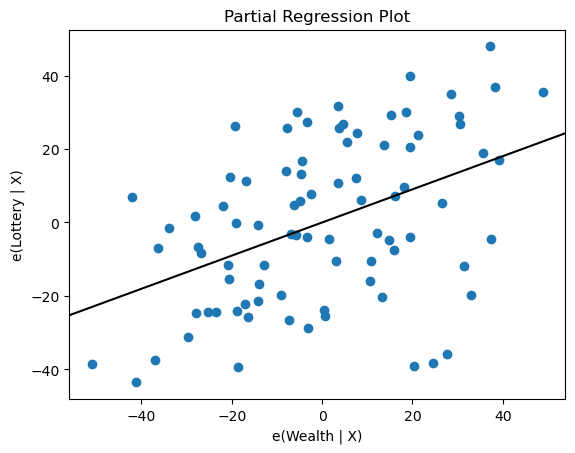

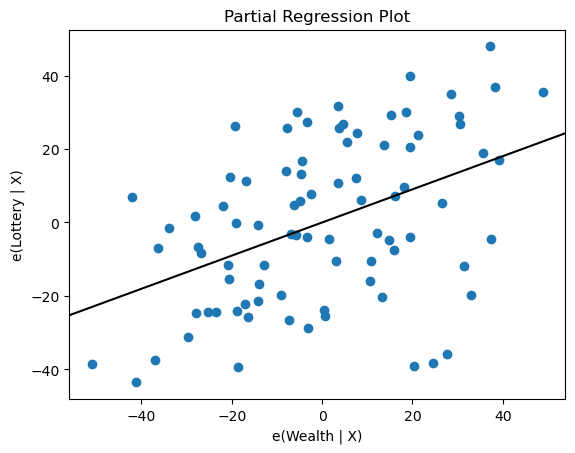

In [42]:
sm.graphics.plot_partregress('Lottery', 'Wealth', ['Region', 'Literacy'], data=df, obs_labels=False)